In [43]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
import os
import pathlib
import pandas as pd
import numpy as np
import re
import upsetplot
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
import seaborn as sns
from proteobench.modules.quant.quant_lfq_ion_DIA_Astral import DIAQuantIonModuleAstral
from proteobench.io.params.alphadia import extract_params as extract_alphadia_params
from proteobench.io.params.diann import extract_params as extract_diann_params
from proteobench.io.params.fragger import extract_params as extract_fragpipe_params
from proteobench.io.params.maxquant import extract_params as extract_maxquant_params
from proteobench.io.params.msaid import extract_params as extract_msaid_params
from proteobench.io.params.spectronaut import (
    read_spectronaut_settings as extract_spectronaut_params,
)
from proteobench.io.params.peaks import extract_params as extract_peaks_params
from proteobench.datapoint.quant_datapoint import (
    filter_df_numquant_epsilon,
    filter_df_numquant_nr_prec,
)
from proteobench.plotting.plot_quant import PlotDataPoint
from plotly.subplots import make_subplots
from proteobench.utils.server_io import get_merged_json, get_raw_data

from matplotlib.colors import to_rgba

In [44]:
MAPPERS = {
    "FragPipe (DIA-NN quant)": {
        "LFQ_Astral_DIA_15min_50ng_Condition_A_REP1 Intensity": "LFQ_Astral_DIA_15min_50ng_Condition_A_REP1",
        "LFQ_Astral_DIA_15min_50ng_Condition_A_REP2 Intensity": "LFQ_Astral_DIA_15min_50ng_Condition_A_REP1",
        "LFQ_Astral_DIA_15min_50ng_Condition_A_REP3 Intensity": "LFQ_Astral_DIA_15min_50ng_Condition_A_REP3",
        "LFQ_Astral_DIA_15min_50ng_Condition_B_REP1 Intensity": "LFQ_Astral_DIA_15min_50ng_Condition_B_REP1",
        "LFQ_Astral_DIA_15min_50ng_Condition_B_REP2 Intensity": "LFQ_Astral_DIA_15min_50ng_Condition_B_REP2",
        "LFQ_Astral_DIA_15min_50ng_Condition_B_REP3 Intensity": "LFQ_Astral_DIA_15min_50ng_Condition_B_REP3",
    },
}

# Download the data

In [45]:
# Astral
Astral_df = get_merged_json(
    repo_url="https://github.com/Proteobench/Results_quant_ion_DIA_Astral/archive/refs/heads/main.zip",
    outfile_name="astral_df.json",
    write_to_file=True,
)
hash_dict_astral = get_raw_data(df=Astral_df)
# diaPASEF
diaPASEF_df = get_merged_json(
    repo_url="https://github.com/Proteobench/Results_quant_ion_DIA_diaPASEF/archive/refs/heads/main.zip",
    outfile_name="diapasef_df.json",
    write_to_file=True,
)
hash_dict_diapasef = get_raw_data(df=diaPASEF_df)

Downloaded ZIP archive from https://github.com/Proteobench/Results_quant_ion_DIA_Astral/archive/refs/heads/main.zip
zip_bytes size: 37735 bytes
Processing file: 075c03fb965a268e1e3b132c5d452121fa2981aa.json
Processing file: 0f60bf20ee5a36effcbc621ae7e888f9319200f0.json
Processing file: 11d1e3cad24d35b31110e82274bd0fef65435a34.json
Processing file: 29f30988632ca71c66213d7e4419673ec88c09d5.json
Processing file: 2db7d789705e1472baec247bf97bd4900fdc2f52.json
Processing file: 2e11c7b3045fe05d9ad8131acd3cb6c43bcd886c.json
Processing file: 2eb6ecaa7ea57027adfdfd5db564f0a3d536f494.json
Processing file: 33855a035ca062218f396f2294ee31ee27b8e485.json
Processing file: 532ea16545e8f9f2c00b3827e47da27043666ae3.json
Processing file: 72e5d1a308ebe49bcc6c1bc7537209b776148bc8.json
Processing file: 73c1ca8853d4f6d90ca6e6c62cd553474ba79061.json
Processing file: 887471e3771f74d27eff4f7f89b34e9fde53214a.json
Processing file: 892ad39ce5323fbc36879952e043c5ecced7e904.json
Processing file: a762a3323caad86de91d

In [46]:
Astral_df

,old_new,id,software_name,software_version,search_engine,search_engine_version,ident_fdr_psm,ident_fdr_peptide,ident_fdr_protein,enable_match_between_runs,...,results.2.CV_q75,results.2.CV_q95,results.1.median_abs_epsilon,results.1.mean_abs_epsilon,results.1.variance_epsilon,results.1.nr_prec,results.1.CV_median,results.1.CV_q90,results.1.CV_q75,results.1.CV_q95
0,new,DIA-NN_20250522_162226,DIA-NN,1.8.2 beta 8,DIA-NN,1.8.2 beta 8,0.01,NaN,NaN,True,...,0.307972,0.607608,0.248120,0.403046,0.381181,120060,0.168464,0.484194,0.307972,0.607608
1,new,DIA-NN_20250605_170158,DIA-NN,1.9.2,DIA-NN,1.9.2,0.01,NaN,NaN,True,...,0.271231,0.528144,0.225346,0.356463,0.283995,126769,0.151665,0.420400,0.271231,0.528144
2,new,AlphaDIA_20250605_170349,AlphaDIA,1.10.3,AlphaDIA,NaN,0.01,NaN,0.01,False,...,0.284733,0.513989,0.268363,0.446830,0.548380,25788,0.163909,0.402962,0.284733,0.513989
3,new,DIA-NN_20250605_174657,DIA-NN,1.9.2,DIA-NN,1.9.2,0.01,NaN,NaN,True,...,0.277242,0.679724,0.239501,0.478147,0.809169,126769,0.151427,0.461329,0.277242,0.679724
4,new,DIA-NN_20250605_175034,DIA-NN,1.9.2,DIA-NN,1.9.2,0.01,NaN,NaN,True,...,0.274159,0.677522,0.237170,0.475916,0.806061,126769,0.150366,0.457775,0.274159,0.677522
5,new,DIA-NN_20250626_092915,DIA-NN,1.9.2,DIA-NN,1.9.2,0.01,NaN,0.01,True,...,0.271740,0.535844,0.224954,0.362536,0.298897,123664,0.150735,0.425165,0.271740,0.535844
6,new,Spectronaut_20250605_171849,Spectronaut,19.9.250512.62635,Spectronaut,19.9.250512.62635,0.01,None,0.01,False,...,0.344369,0.731712,0.246048,0.433402,0.485068,120802,0.180407,0.571737,0.344369,0.731712
7,new,DIA-NN_20250605_175300,DIA-NN,2.0 Academia,DIA-NN,2.0 Academia,0.01,NaN,NaN,True,...,0.260588,0.507624,0.229189,0.376576,0.391124,131738,0.150051,0.399688,0.260588,0.507624
8,new,AlphaDIA_20250627_150126,AlphaDIA,1.10.4-dev0,AlphaDIA,NaN,0.01,NaN,0.01,True,...,0.363845,0.641562,0.325251,0.455675,0.413095,106824,0.230141,0.519217,0.363845,0.641562
9,new,AlphaDIA_20250605_164604,AlphaDIA,1.10.3,AlphaDIA,NaN,0.01,NaN,0.01,True,...,0.347079,0.678476,0.349815,0.768377,1.645439,38162,0.216065,0.522513,0.347079,0.678476


# Functions

In [ ]:
def extract_all_from_hashes(hashes, data_dir="extracted_files", module=DIAQuantIonModuleAstral(token="")):
    """Extract all results from hashes."""
    all_datapoints = pd.DataFrame()
    results_dict = {}
    comments = []

    for point_hash, tool in hashes.items():
        print(f"Processing {point_hash} - {tool}")
        if not tool in results_dict:
            results_dict[tool] = {}

        raw_data_path = f"{data_dir}/{point_hash}/input_file"  # Extension can vary
        param_path = f"{data_dir}/{point_hash}/param_0."  # Extension can vary

        # Identify the correct raw data file extension. There can be only one raw data file per point_hash.
        raw_data_files = list(pathlib.Path(raw_data_path).parent.glob(f"{pathlib.Path(raw_data_path).name}.*"))
        print(f"Raw data files found: {raw_data_files}")
        # Identify the correct parameter file extension. There can be only one parameter file per point_hash.
        param_files = list(pathlib.Path(param_path).parent.glob(f"{pathlib.Path(param_path).name}.*"))
        print(f"Parameter files found: {param_files}")

        if not raw_data_files or not param_files:
            print(f"Skipping {point_hash} - {tool}: No raw data or parameter files found.")
            continue
        raw_data_path = raw_data_files[0]
        param_path = param_files[0]

        if "FragPipe" in tool or "AlphaPept" in tool:
            param_path = open(param_path, "rb")

        extract_params_func = globals()[f"extract_{tool.replace('-', '').lower().replace(' (diann quant)', '')}_params"]
        param_data = extract_params_func(param_path).__dict__
        results_performance, all_datapoints, _ = module.benchmarking(
            raw_data_path, tool, user_input=param_data, all_datapoints=all_datapoints
        )

        if "MaxQuant" in tool:
            print("adding carbamidos to maxquant")
            results_performance["precursor ion"] = results_performance["precursor ion"].apply(
                lambda x: x.replace("C", "C[Carbamidomethyl]")
            )

        results_dict[tool][point_hash] = results_performance
    # Set all datapoints to old
    all_datapoints["old_new"] = "old"
    return results_dict, all_datapoints

In [ ]:
def prepare_datapoints(all_datapoints, min_quant=3):
    """Filter and calculate metrics for data points."""
    all_datapoints["median_abs_epsilon"] = [
        filter_df_numquant_epsilon(v, min_quant=min_quant) for v in all_datapoints["results"]
    ]
    all_datapoints["nr_prec"] = [filter_df_numquant_nr_prec(v, min_quant=min_quant) for v in all_datapoints["results"]]
    return all_datapoints


def plot_performance_metrics(
    all_datapoints,
    min_quant=3,
    metric="Median",
    subset=None,
    x_range=None,
    y_range=None,
    subset_col="id",
):
    """Plot performance metrics for data points."""
    if subset:
        all_datapoints = all_datapoints[all_datapoints[subset_col].isin(subset)]
    all_datapoints = prepare_datapoints(all_datapoints, min_quant=min_quant)
    plot = PlotDataPoint.plot_metric(
        all_datapoints,
        metric=metric,
        hide_annot=True,
    )
    plot.update_layout(
        xaxis=dict(range=x_range) if x_range else {},
        yaxis=dict(range=y_range) if y_range else {},
    )

    return plot


def plot_performance_metrics_all_filters(
    all_datapoints,
    x_range,
    y_range,
    metric="Median",
    subset=None,
    subset_col="id",
):

    if subset:
        all_datapoints = all_datapoints[all_datapoints[subset_col].isin(subset)]

    plots = []
    for min_quant in range(1, 7):
        datapoints = prepare_datapoints(all_datapoints, min_quant=min_quant)
        plot = PlotDataPoint.plot_metric(datapoints, metric=metric, hide_annot=True)
        plot.update_layout(xaxis=dict(range=x_range), yaxis=dict(range=y_range))
        plots.append(plot)

    combined_fig = make_subplots(
        rows=2,
        cols=3,
        subplot_titles=[f"Min. quantified ions: {i}" for i in range(1, 7)],
    )

    positions = [(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3)]

    for fig, (r, c) in zip(plots, positions):
        for trace in fig.data:
            combined_fig.add_trace(trace, row=r, col=c)

            combined_fig.update_xaxes(range=x_range, row=r, col=c)
            combined_fig.update_yaxes(range=y_range, row=r, col=c)

    combined_fig.update_layout(height=800, width=1200)

    # remove duplicate legend items
    names = set()
    combined_fig.for_each_trace(
        lambda trace: (trace.update(showlegend=False) if (trace.name in names) else names.add(trace.name))
    )

    return combined_fig


def prepare_performance_dict(results, mappers=MAPPERS, mapper=None, subset=None):
    """Prepare a dictionary of performance results."""
    if subset:
        results = {k: {sk: v for sk, v in inner_dict.items() if sk in subset} for k, inner_dict in results.items()}
    print(results)

    performance_dict = {}
    for tool, subdict in results.items():
        print(f"Processing {tool}")
        print(f"Tool has the following runs: {subdict.keys()}")
        for run_name, df in subdict.items():
            print(f"Processing {run_name}")
            if mapper != None:
                df = df.rename(columns=mappers[mapper])
            elif tool in mappers:
                tool_mapper = mappers[tool]
                df = df.rename(columns=tool_mapper)

            df.columns = [x.replace(".mzML", "") for x in df.columns]
            performance_dict[tool] = df
    return performance_dict

In [ ]:
def filter_upset_data(data, tools):
    # Filter the data so that only subsets are plotted that contain sequences from all tools, from all-but-one tool, or from only one tool
    data_index_reset = data.reset_index()
    ids = data_index_reset["id"]
    occurrences = data_index_reset.drop(columns="id")
    occurrences = occurrences.astype(int)
    row_sums = occurrences.sum(axis=1)
    # Turn row_sums into a dataframe
    row_sums = pd.DataFrame(row_sums)
    row_sums = row_sums.rename(columns={0: "Number of tools"})
    row_sums["id"] = ids
    filtered_data = data_index_reset[
        (row_sums["Number of tools"] == len(tools))
        | (row_sums["Number of tools"] == len(tools) - 1)
        | (row_sums["Number of tools"] == 1)
    ]
    filtered_data = filtered_data.set_index(tools)
    return filtered_data


def add_epsilons(data, df_dict):
    # Store the original index
    data_index = data.index
    # Reset the index so that the id column is available for merging
    data = data.reset_index()

    for tool, df in df_dict.items():
        # Merge the id column from df with the epsilon column from tool_df
        print(tool)
        data = data.merge(
            df[["precursor ion", "epsilon"]],
            left_on="id",
            right_on="precursor ion",
            how="left",
        )
        data.to_csv(f"analysis_debug/{tool}_epsilon.csv")

        data = data.rename(columns={"epsilon": f"{tool}_epsilon"})
        data = data.drop(columns=["precursor ion"])

    # Set the index back to the original index
    data = data.set_index(data_index.names)
    return data


def upsetplot_from_df_dict(df_dict):
    sequence_dict = {}
    for tool, df in df_dict.items():
        # Each df should have a "sequence" column
        unique_sequences = df["precursor ion"].unique()
        # Store the sequences in a list and add it to the dictionary
        sequence_dict[tool] = set(unique_sequences)

    # Create the upset plot
    sequences = upsetplot.from_contents(sequence_dict)
    tools = list(df_dict.keys())
    filtered_sequences = filter_upset_data(sequences, tools)
    data_with_epsilons = add_epsilons(filtered_sequences, df_dict)

    return data_with_epsilons


def plot_boxplot(boxplot_data, ax):
    boxplot_data["absolute epsilon"] = boxplot_data["epsilon"].abs()

    # Draw the stripplot with a custom palette
    sns.boxplot(
        data=boxplot_data,
        x="workflow",
        y="absolute epsilon",
        hue="quantified by",
        ax=ax,
        showfliers=False,
        linewidth=1,
    )
    # sns.violinplot(data=boxplot_data, x="tool", y="epsilon", hue = "unique or all", ax=ax, inner=None, linewidth=1)

    # Add the number of observations to each boxplot

    # Improve aesthetics of labels and title
    ax.set_ylabel("Error between measured and expected logFC", fontsize=7, fontweight="bold")
    # rotate
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment="right")

    # Add subtle grid lines to enhance readability
    ax.yaxis.grid(True, linestyle="--", color="gray", alpha=0.7)
    ax.xaxis.grid(False)  # Only y-axis grid for cleaner look

    # make y label bigger
    ax.yaxis.label.set_size(12)

    # Add a tighter layout for better spacing
    plt.tight_layout()


def strip_peptidoform(peptidoform):
    no_mods = re.sub(r"\[.*?\]", "", peptidoform)
    no_mods = no_mods.replace("-", "")
    return no_mods


def filter_df(df):
    df["precursor ion"] = df["precursor ion"].apply(strip_peptidoform)
    df.drop_duplicates(subset="precursor ion", inplace=True, keep="first")
    return df


def plot_upset_and_boxplot(df_dict, mapper, stripped=False):

    if stripped:
        df_dict_copy = df_dict.copy()
        df_dict_copy = {key: filter_df(val) for key, val in df_dict_copy.items()}

    else:
        df_dict_copy = df_dict.copy()

    boxplotdata = upsetplot_from_df_dict(df_dict_copy)
    fig, ax_upset = plt.subplots(1, 1, figsize=(6, 3))

    # plot upset plot
    matplotlib.rcParams.update({"font.size": 10})
    upset = upsetplot.UpSet(
        boxplotdata,
        subset_size="count",
        include_empty_subsets=False,
        sort_categories_by="input",
    )
    upset.style_subsets(min_degree=1, facecolor="#3274A1")
    upset.style_subsets(min_degree=2, facecolor="black")
    upset.style_subsets(min_degree=6, facecolor="#E1812C")
    upset.plot(fig=fig)
    ax_upset.grid(False)

    # Hide x-axis label and ticks
    ax_upset.set_xlabel("")
    ax_upset.set_xticks([])
    ax_upset.set_ylabel("")
    ax_upset.set_yticks([])

    # Hide the box
    ax_upset.spines["top"].set_visible(False)
    ax_upset.spines["right"].set_visible(False)
    ax_upset.spines["left"].set_visible(False)
    ax_upset.spines["bottom"].set_visible(False)

    for text in fig.findobj(match=plt.Text):
        text.set_fontsize(8)

    # color the same as boxplot

    # plot boxplot, sorted the same way as the upset plot
    boxplotdata = boxplotdata.reset_index()

    # this needs to be adapted to the number of tools... currently hardcoded :( sorry
    boxplotdata["index_list"] = boxplotdata[boxplotdata.columns[:6]].values.tolist()

    boxplotdata["eval"] = boxplotdata["index_list"].apply(str).map(mapper)

    # drop all ions that are neither all or unique
    boxplotdata = boxplotdata.dropna(subset=["eval"])
    boxplotdata.to_csv("boxplotdata.csv")
    epsilon_cols = [col for col in boxplotdata.columns if "_epsilon" in col]
    important_cols = epsilon_cols + ["eval"]
    boxplotdata = boxplotdata[important_cols]

    boxplotdata["eval"] = pd.Categorical(boxplotdata["eval"], categories=mapper.values(), ordered=True)
    boxplotdata = boxplotdata.sort_values("eval")

    # turn to long format for plotting
    boxplotdata_final = pd.DataFrame()
    for col in epsilon_cols:
        temp = boxplotdata[["eval", col]]
        tool = col.split("_epsilon")[0]
        ions = temp[(temp["eval"] == tool) | (temp["eval"] == "all")]
        ions["quantified by"] = ions["eval"].apply(lambda x: "all" if x == "all" else "unique")
        ions["workflow"] = tool
        ions = ions.rename(columns={col: "epsilon"})
        ions = ions.drop(columns=["eval"]).reset_index(drop=True)
        boxplotdata_final = pd.concat([boxplotdata_final, ions])

    boxplotdata_final.reset_index(drop=True, inplace=True)

    # Set the style
    fig, box_ax = plt.subplots(figsize=(10, 6))
    fig_box = plot_boxplot(boxplotdata_final, ax=box_ax)
    plt.show()
    return fig, fig_box


def plot_upset_and_boxplot_all_filters(df_dict, mapper, save_path="figures_manuscript/"):

    for i in range(1, 7):

        # filter the df dict
        df_dict_filtered = {key: value[value["nr_observed"] >= i] for key, value in df_dict.items()}

        boxplotdata = upsetplot_from_df_dict(df_dict_filtered)
        fig, ax_upset = plt.subplots(1, 1, figsize=(6, 3))

        # plot upset plot
        matplotlib.rcParams.update({"font.size": 10})
        upset = upsetplot.UpSet(
            boxplotdata,
            subset_size="count",
            include_empty_subsets=False,
            sort_categories_by="input",
        )
        upset.style_subsets(min_degree=1, facecolor="#3274A1")
        upset.style_subsets(min_degree=2, facecolor="black")
        upset.style_subsets(min_degree=5, facecolor="#E1812C")
        upset.plot(fig=fig)
        # Save the upset plot

        ax_upset.grid(False)
        # Hide x-axis label and ticks
        ax_upset.set_xlabel("")
        ax_upset.set_xticks([])
        ax_upset.set_ylabel("")
        ax_upset.set_yticks([])
        # Hide the box
        ax_upset.spines["top"].set_visible(False)
        ax_upset.spines["right"].set_visible(False)
        ax_upset.spines["left"].set_visible(False)
        ax_upset.spines["bottom"].set_visible(False)

        for text in fig.findobj(match=plt.Text):
            text.set_fontsize(8)

        fig.savefig(
            save_path + f"upset_plot_min_quant_{i}.svg",
        )

        n_tools = int((len(mapper.keys()) - 1) / 2)
        # plot boxplot, sorted the same way as the upset plot
        boxplotdata = boxplotdata.reset_index()

        boxplotdata["index_list"] = boxplotdata[boxplotdata.columns[:n_tools]].values.tolist()
        boxplotdata["eval"] = boxplotdata["index_list"].apply(str).map(mapper)

        # # drop all ions that are neither all or unique
        # boxplotdata = boxplotdata.dropna(subset=["eval"])
        epsilon_cols = [col for col in boxplotdata.columns if "_epsilon" in col]
        important_cols = epsilon_cols + ["eval"]
        boxplotdata = boxplotdata[important_cols]

        boxplotdata["eval"] = pd.Categorical(boxplotdata["eval"], categories=mapper.values(), ordered=True)
        boxplotdata = boxplotdata.sort_values("eval")

        # turn to long format for plotting
        boxplotdata_final = pd.DataFrame()
        for col in epsilon_cols:
            temp = boxplotdata[["eval", col]]
            tool = col.split("_epsilon")[0]
            ions = temp[(temp["eval"] == tool) | (temp["eval"] == "all")]
            ions["quantified by"] = ions["eval"].apply(lambda x: "all" if x == "all" else "unique")
            ions["workflow"] = tool
            ions = ions.rename(columns={col: "epsilon"})
            ions = ions.drop(columns=["eval"]).reset_index(drop=True)
            boxplotdata_final = pd.concat([boxplotdata_final, ions])

        boxplotdata_final.reset_index(drop=True, inplace=True)

        # Set the style
        fig, box_ax = plt.subplots(figsize=(10, 6))
        fig_box = plot_boxplot(boxplotdata_final, ax=box_ax)
        plt.title("Min. quantified ions: " + str(i))
        plt.savefig(save_path + f"boxplot_min_quant_{i}.svg")
        plt.show()
    return fig, fig_box

# Module overviews

In [ ]:
relevant_points_Astral = (
    Astral_df[~Astral_df["software_name"].isin(["MaxQuant"])][["software_name", "intermediate_hash"]]
    .set_index("intermediate_hash")
    .to_dict()["software_name"]
)

In [51]:
results_dict, all_datapoints = extract_all_from_hashes(
    relevant_points_Astral,
    data_dir="extracted_files",
    module=DIAQuantIonModuleAstral(token=""),
)

Processing 075c03fb965a268e1e3b132c5d452121fa2981aa - DIA-NN
Raw data files found: []
Parameter files found: []
Skipping 075c03fb965a268e1e3b132c5d452121fa2981aa - DIA-NN: No raw data or parameter files found.
Processing 0f60bf20ee5a36effcbc621ae7e888f9319200f0 - DIA-NN
Raw data files found: [PosixPath('extracted_files/0f60bf20ee5a36effcbc621ae7e888f9319200f0/input_file.tsv')]
Parameter files found: [PosixPath('extracted_files/0f60bf20ee5a36effcbc621ae7e888f9319200f0/param_0..txt')]
software_name DIA-NN
search_engine DIA-NN
enable_match_between_runs True
quantification_method Legacy
protein_inference Genes
software_version 1.9.2
search_engine_version 1.9.2
predictors_library {'RT': 'DIANN', 'IM': 'DIANN', 'MS2_int': 'DIANN'}
ident_fdr_psm 0.01
enzyme Trypsin/P
allowed_miscleavages 1
min_peptide_length 6
max_peptide_length 30
fixed_mods unimod4
variable_mods UniMod:35/15.994915/M,UniMod:1/42.010565/*n
max_mods 1
min_precursor_charge 1
max_precursor_charge 4
fragment_mass_tolerance [-8.3

In [59]:
all_datapoints

,id,software_name,software_version,search_engine,search_engine_version,ident_fdr_psm,ident_fdr_peptide,ident_fdr_protein,enable_match_between_runs,precursor_mass_tolerance,...,results,median_abs_epsilon,mean_abs_epsilon,nr_prec,comments,proteobench_version,old_new,color,hover_text,scatter_size
0,DIA-NN_20250630_161001,DIA-NN,1.9.2,DIA-NN,1.9.2,0.01,None,None,True,"[-2.42372 ppm, 2.42372 ppm]",...,{6: {'median_abs_epsilon': 0.17686970873882846...,0.176870,0.34892,78874,,0.5.16.dev13+gf14d0f6.d20250121,old,#d42f2f,ProteoBench ID: DIA-NN_20250630_161001<br>Soft...,10
1,AlphaDIA_20250630_161006,AlphaDIA,1.10.3,AlphaDIA,None,0.01,None,0.01,False,"[-10 ppm, 10 ppm]",...,"{6: {'median_abs_epsilon': 0.2005678812667142,...",0.200568,0.436842,5747,,0.5.16.dev13+gf14d0f6.d20250121,old,#1D2732,ProteoBench ID: AlphaDIA_20250630_161006<br>So...,10
2,DIA-NN_20250630_161033,DIA-NN,1.9.2,DIA-NN,1.9.2,0.01,None,None,True,"[-2.42372 ppm, 2.42372 ppm]",...,{6: {'median_abs_epsilon': 0.17850750686549244...,0.178508,0.456973,78880,,0.5.16.dev13+gf14d0f6.d20250121,old,#d42f2f,ProteoBench ID: DIA-NN_20250630_161033<br>Soft...,10
3,DIA-NN_20250630_161101,DIA-NN,1.9.2,DIA-NN,1.9.2,0.01,None,None,True,"[-2.42372 ppm, 2.42372 ppm]",...,{6: {'median_abs_epsilon': 0.17714917529627527...,0.177149,0.454716,78880,,0.5.16.dev13+gf14d0f6.d20250121,old,#d42f2f,ProteoBench ID: DIA-NN_20250630_161101<br>Soft...,10
4,DIA-NN_20250630_161127,DIA-NN,1.9.2,DIA-NN,1.9.2,0.01,None,0.01,True,"[-2.31639 ppm, 2.31639 ppm]",...,"{6: {'median_abs_epsilon': 0.1753596937576063,...",0.175360,0.354593,79833,,0.5.16.dev13+gf14d0f6.d20250121,old,#d42f2f,ProteoBench ID: DIA-NN_20250630_161127<br>Soft...,10
5,Spectronaut_20250630_161207,Spectronaut,19.9.250512.62635,Spectronaut,19.9.250512.62635,0.01,,0.01,False,Dynamic,...,{6: {'median_abs_epsilon': 0.20220646737927428...,0.202206,0.422369,92987,,0.5.16.dev13+gf14d0f6.d20250121,old,#007548,ProteoBench ID: Spectronaut_20250630_161207<br...,10
6,DIA-NN_20250630_161226,DIA-NN,2.0 Academia,DIA-NN,2.0 Academia,0.01,None,None,True,"[-2.6 ppm, 2.6 ppm]",...,{6: {'median_abs_epsilon': 0.18008995056152344...,0.180090,0.362523,83219,,0.5.16.dev13+gf14d0f6.d20250121,old,#d42f2f,ProteoBench ID: DIA-NN_20250630_161226<br>Soft...,10
7,AlphaDIA_20250630_161240,AlphaDIA,1.10.4-dev0,AlphaDIA,None,0.01,None,0.01,True,"[-0 ppm, 0 ppm]",...,{6: {'median_abs_epsilon': 0.26972993214945884...,0.269730,0.448934,64504,,0.5.16.dev13+gf14d0f6.d20250121,old,#1D2732,ProteoBench ID: AlphaDIA_20250630_161240<br>So...,10
8,AlphaDIA_20250630_161247,AlphaDIA,1.10.3,AlphaDIA,None,0.01,None,0.01,True,"[-3 ppm, 3 ppm]",...,"{6: {'median_abs_epsilon': 0.2602551778099915,...",0.260255,0.764985,15041,,0.5.16.dev13+gf14d0f6.d20250121,old,#1D2732,ProteoBench ID: AlphaDIA_20250630_161247<br>So...,10
9,Spectronaut_20250630_161315,Spectronaut,19.5.241126.62635,Spectronaut,19.5.241126.62635,0.01,,0.01,False,Dynamic,...,{6: {'median_abs_epsilon': 0.21302303530482547...,0.213023,0.443617,91501,,0.5.16.dev13+gf14d0f6.d20250121,old,#007548,ProteoBench ID: Spectronaut_20250630_161315<br...,10


In [60]:
plot = plot_performance_metrics(
    all_datapoints,
    metric="Median",
    x_range=[0.1, 0.4],
    y_range=[60000, 150000],
    min_quant=3,
)
plot

In [61]:
plot = plot_performance_metrics(
    all_datapoints,
    metric="Mean",
    x_range=[0.1, 0.6],
    y_range=[60000, 150000],
    min_quant=3,
)
# Save the plot
plot

In [ ]:
plot = plot_performance_metrics_all_filters(all_datapoints, x_range=[0, 0.4], y_range=[0, 190000], metric="Median")
plot

In [ ]:
plot = plot_performance_metrics_all_filters(all_datapoints, x_range=[0, 0.6], y_range=[0, 190000], metric="Mean")
plot

# Default settings, compare search engines

In [64]:
all_datapoints

,id,software_name,software_version,search_engine,search_engine_version,ident_fdr_psm,ident_fdr_peptide,ident_fdr_protein,enable_match_between_runs,precursor_mass_tolerance,...,results,median_abs_epsilon,mean_abs_epsilon,nr_prec,comments,proteobench_version,old_new,color,hover_text,scatter_size
0,DIA-NN_20250630_161001,DIA-NN,1.9.2,DIA-NN,1.9.2,0.01,None,None,True,"[-2.42372 ppm, 2.42372 ppm]",...,{6: {'median_abs_epsilon': 0.17686970873882846...,0.176870,0.34892,78874,,0.5.16.dev13+gf14d0f6.d20250121,old,#d42f2f,ProteoBench ID: DIA-NN_20250630_161001<br>Soft...,10
1,AlphaDIA_20250630_161006,AlphaDIA,1.10.3,AlphaDIA,None,0.01,None,0.01,False,"[-10 ppm, 10 ppm]",...,"{6: {'median_abs_epsilon': 0.2005678812667142,...",0.200568,0.436842,5747,,0.5.16.dev13+gf14d0f6.d20250121,old,#1D2732,ProteoBench ID: AlphaDIA_20250630_161006<br>So...,10
2,DIA-NN_20250630_161033,DIA-NN,1.9.2,DIA-NN,1.9.2,0.01,None,None,True,"[-2.42372 ppm, 2.42372 ppm]",...,{6: {'median_abs_epsilon': 0.17850750686549244...,0.178508,0.456973,78880,,0.5.16.dev13+gf14d0f6.d20250121,old,#d42f2f,ProteoBench ID: DIA-NN_20250630_161033<br>Soft...,10
3,DIA-NN_20250630_161101,DIA-NN,1.9.2,DIA-NN,1.9.2,0.01,None,None,True,"[-2.42372 ppm, 2.42372 ppm]",...,{6: {'median_abs_epsilon': 0.17714917529627527...,0.177149,0.454716,78880,,0.5.16.dev13+gf14d0f6.d20250121,old,#d42f2f,ProteoBench ID: DIA-NN_20250630_161101<br>Soft...,10
4,DIA-NN_20250630_161127,DIA-NN,1.9.2,DIA-NN,1.9.2,0.01,None,0.01,True,"[-2.31639 ppm, 2.31639 ppm]",...,"{6: {'median_abs_epsilon': 0.1753596937576063,...",0.175360,0.354593,79833,,0.5.16.dev13+gf14d0f6.d20250121,old,#d42f2f,ProteoBench ID: DIA-NN_20250630_161127<br>Soft...,10
5,Spectronaut_20250630_161207,Spectronaut,19.9.250512.62635,Spectronaut,19.9.250512.62635,0.01,,0.01,False,Dynamic,...,{6: {'median_abs_epsilon': 0.20220646737927428...,0.202206,0.422369,92987,,0.5.16.dev13+gf14d0f6.d20250121,old,#007548,ProteoBench ID: Spectronaut_20250630_161207<br...,10
6,DIA-NN_20250630_161226,DIA-NN,2.0 Academia,DIA-NN,2.0 Academia,0.01,None,None,True,"[-2.6 ppm, 2.6 ppm]",...,{6: {'median_abs_epsilon': 0.18008995056152344...,0.180090,0.362523,83219,,0.5.16.dev13+gf14d0f6.d20250121,old,#d42f2f,ProteoBench ID: DIA-NN_20250630_161226<br>Soft...,10
7,AlphaDIA_20250630_161240,AlphaDIA,1.10.4-dev0,AlphaDIA,None,0.01,None,0.01,True,"[-0 ppm, 0 ppm]",...,{6: {'median_abs_epsilon': 0.26972993214945884...,0.269730,0.448934,64504,,0.5.16.dev13+gf14d0f6.d20250121,old,#1D2732,ProteoBench ID: AlphaDIA_20250630_161240<br>So...,10
8,AlphaDIA_20250630_161247,AlphaDIA,1.10.3,AlphaDIA,None,0.01,None,0.01,True,"[-3 ppm, 3 ppm]",...,"{6: {'median_abs_epsilon': 0.2602551778099915,...",0.260255,0.764985,15041,,0.5.16.dev13+gf14d0f6.d20250121,old,#1D2732,ProteoBench ID: AlphaDIA_20250630_161247<br>So...,10
9,Spectronaut_20250630_161315,Spectronaut,19.5.241126.62635,Spectronaut,19.5.241126.62635,0.01,,0.01,False,Dynamic,...,{6: {'median_abs_epsilon': 0.21302303530482547...,0.213023,0.443617,91501,,0.5.16.dev13+gf14d0f6.d20250121,old,#007548,ProteoBench ID: Spectronaut_20250630_161315<br...,10


In [65]:
subset_hashes = [
    "887471e3771f74d27eff4f7f89b34e9fde53214a",
    "b342522520beee8fa15304c6683eed7a2f68e01f",
    "e73895810db40bfd105c17fe51e904396e66eb05",
    "f81ee4e856cfe429a771785c55020f68ec1fd746",
    "532ea16545e8f9f2c00b3827e47da27043666ae3",
]

In [ ]:
plot = plot_performance_metrics(all_datapoints, subset=subset_hashes, min_quant=3, subset_col="intermediate_hash")
plot

In [67]:
plot = plot_performance_metrics(
    all_datapoints,
    metric="Mean",
    subset=subset_hashes,
    min_quant=3,
    subset_col="intermediate_hash",
)
plot

In [108]:
plot = plot_performance_metrics_all_filters(
    all_datapoints,
    x_range=[0.15, 0.35],
    y_range=[0, 160000],
    metric="Median",
    subset=subset_hashes,
    subset_col="intermediate_hash",
)
plot

In [69]:
plot = plot_performance_metrics_all_filters(
    all_datapoints,
    x_range=[0, 0.8],
    y_range=[0, 160000],
    metric="Mean",
    subset=subset_hashes,
    subset_col="intermediate_hash",
)
plot

# Intersection between all the search engines: How do the unique quantifications perform?

In [77]:
subset_hashes = [
    "887471e3771f74d27eff4f7f89b34e9fde53214a",
    "b342522520beee8fa15304c6683eed7a2f68e01f",
    "e73895810db40bfd105c17fe51e904396e66eb05",
    "cdd362f6d906a860202bef7cb30d66bce09939f6",
    "532ea16545e8f9f2c00b3827e47da27043666ae3",
]

In [86]:
all_tools_mapper = {
    "[True, False, False, False, False]": "DIA-NN",
    "[False, True, False, False, False]": "AlphaDIA",
    "[False, False, True, False, False]": "Spectronaut",
    "[False, False, False, True, False]": "PEAKS",
    "[False, False, False, False, True]": "FragPipe (DIA-NN quant)",
    "[False, True, True, True, True]": "all but  Fragpipe (DIA-NN quant)",
    "[True, False, True, True, True]": "all but PEAKS",
    "[True, True, False, True, True]": "all but Spectronaut",
    "[True, True, True,  False, True]": "all but AlphaDIA",
    "[True, True, True, True, False]": "all but DIA-NN",
    "[True, True, True, True, True]": "all",
}

In [80]:
performance_df_dict.keys()

dict_keys(['DIA-NN', 'AlphaDIA', 'Spectronaut', 'PEAKS', 'FragPipe (DIA-NN quant)'])

In [ ]:
performance_df_dict = prepare_performance_dict(results_dict, mapper=None, subset=subset_hashes)

{'DIA-NN': {'cdd362f6d906a860202bef7cb30d66bce09939f6':                            precursor ion  log_Intensity_mean_A   
0                        AAAAAAALQAK|Z=2             23.052261  \
1                         AAAAAAGEAR|Z=2             14.045571   
2                         AAAAADLANR|Z=2             19.963017   
3                    AAAAALSQQQSLQER|Z=2             13.641426   
4       AAAAATVVPPMVGGPPFVGPVGFGPGDR|Z=3             15.554988   
...                                  ...                   ...   
136443          [Acetyl]-VDPVGFAEAWK|Z=2             18.120216   
136444          [Acetyl]-VDYYEVLGVQR|Z=2             16.678129   
136445              [Acetyl]-VEEENIR|Z=2             20.230709   
136446               [Acetyl]-VEEVQK|Z=1             20.422110   
136447       [Acetyl]-VNVVLGSQWGDEGK|Z=2             16.103363   

        log_Intensity_mean_B  log_Intensity_std_A  log_Intensity_std_B   
0                  23.017351             0.054789             0.040360  \
1  

DIA-NN
AlphaDIA
Spectronaut
PEAKS
FragPipe (DIA-NN quant)


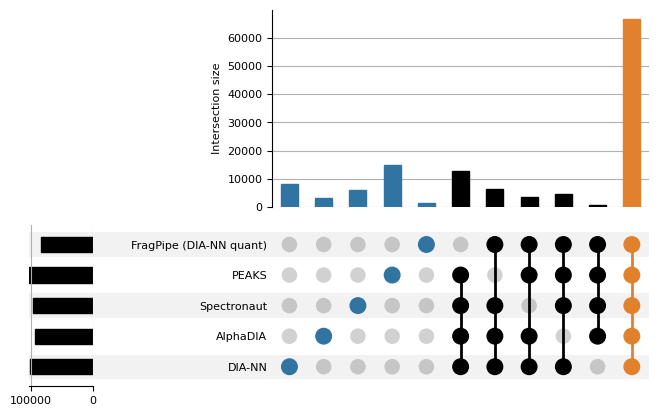

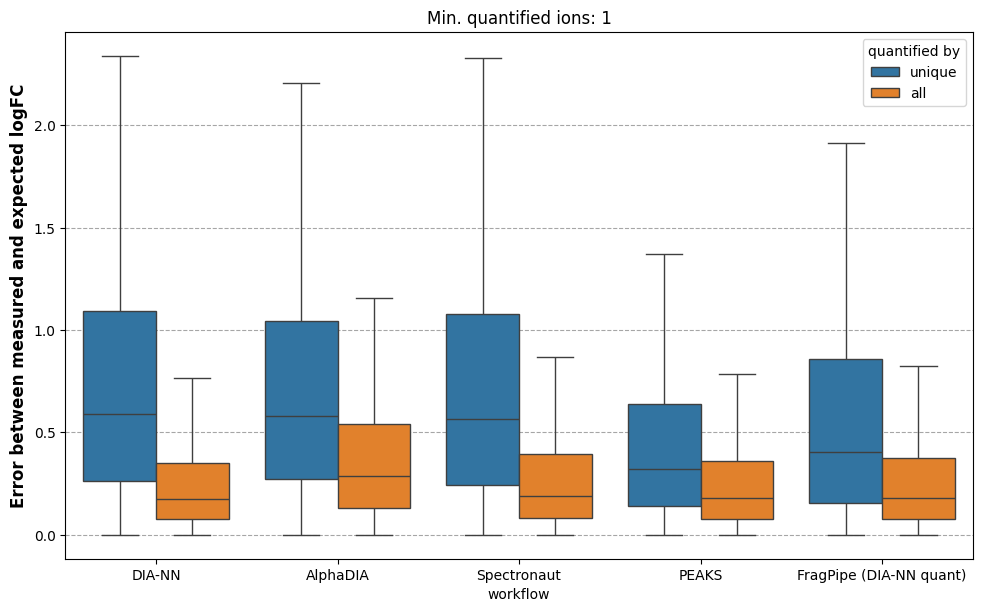

DIA-NN
AlphaDIA
Spectronaut
PEAKS
FragPipe (DIA-NN quant)


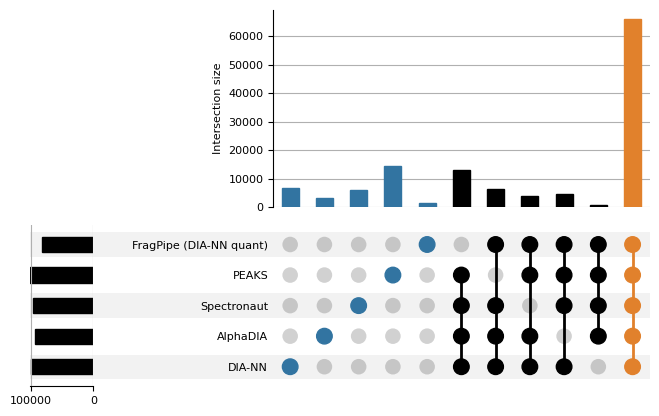

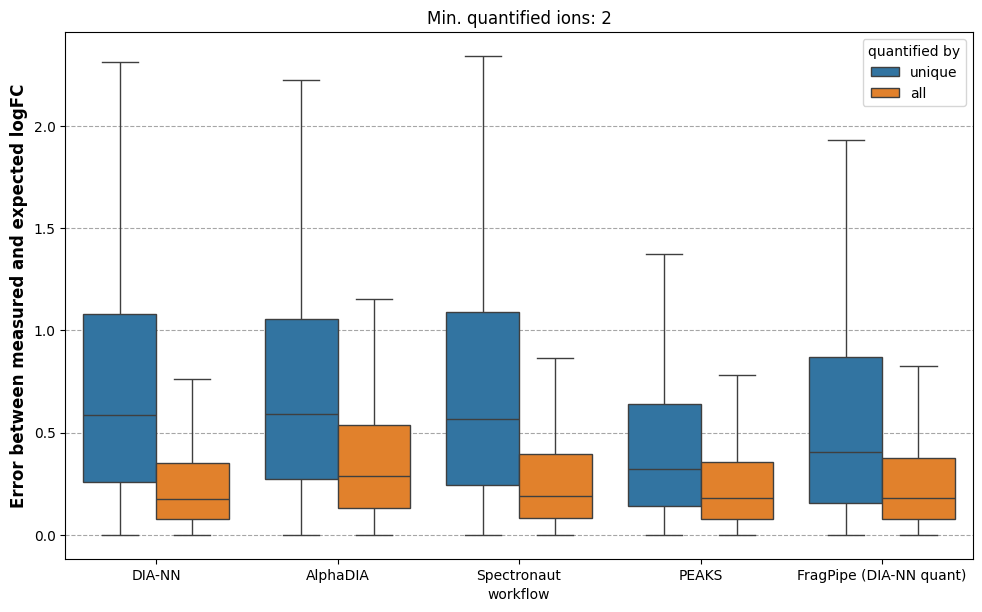

DIA-NN
AlphaDIA
Spectronaut
PEAKS
FragPipe (DIA-NN quant)


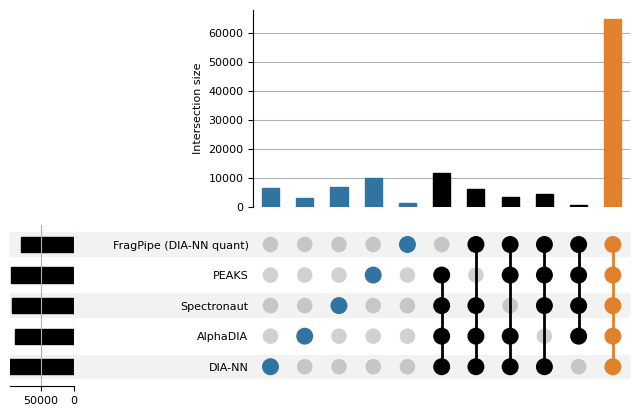

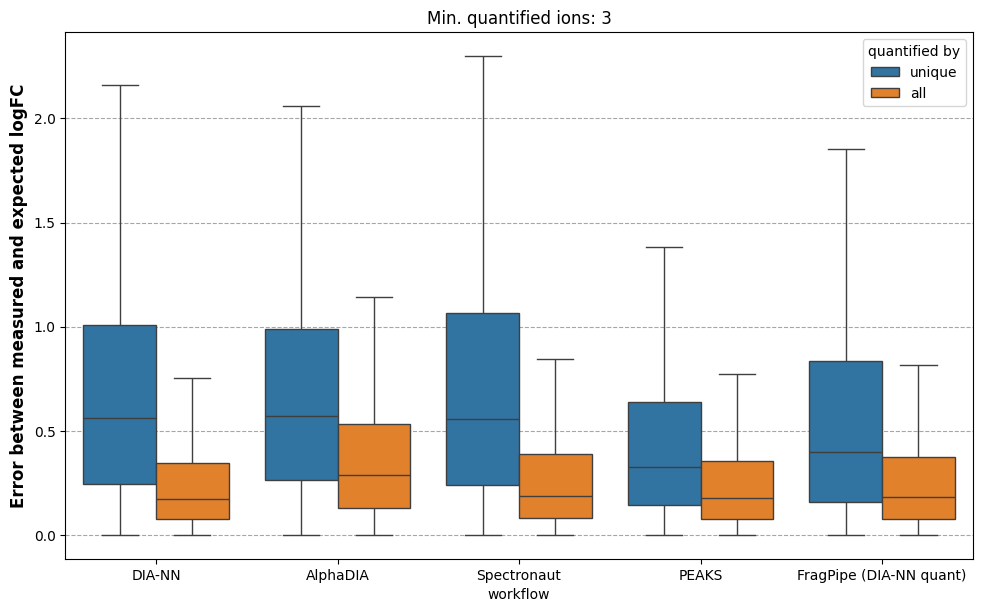

DIA-NN
AlphaDIA
Spectronaut
PEAKS
FragPipe (DIA-NN quant)


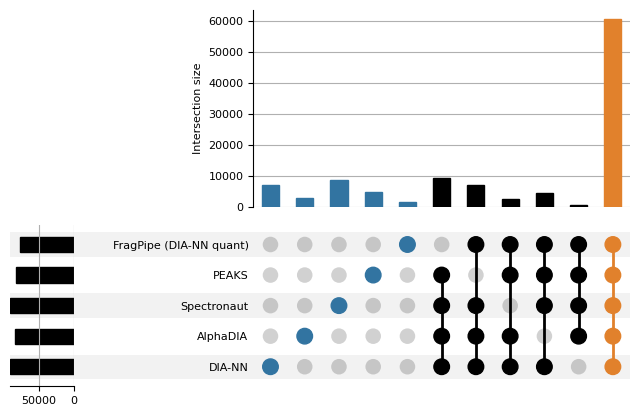

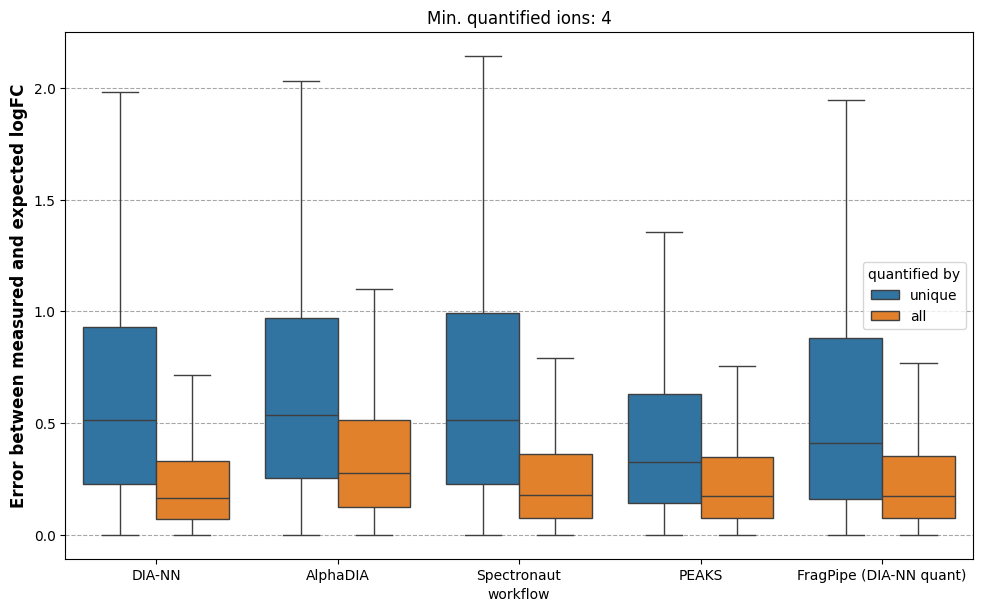

DIA-NN
AlphaDIA
Spectronaut
PEAKS
FragPipe (DIA-NN quant)


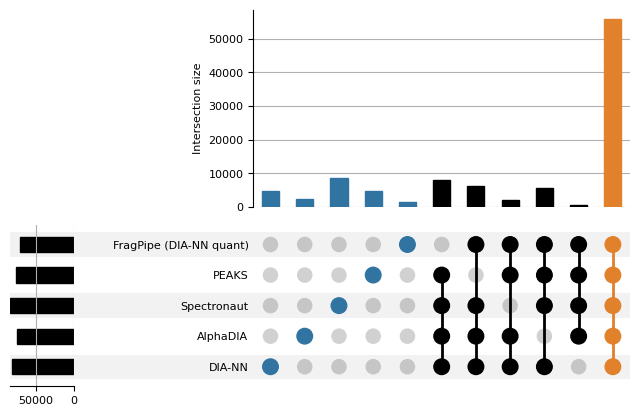

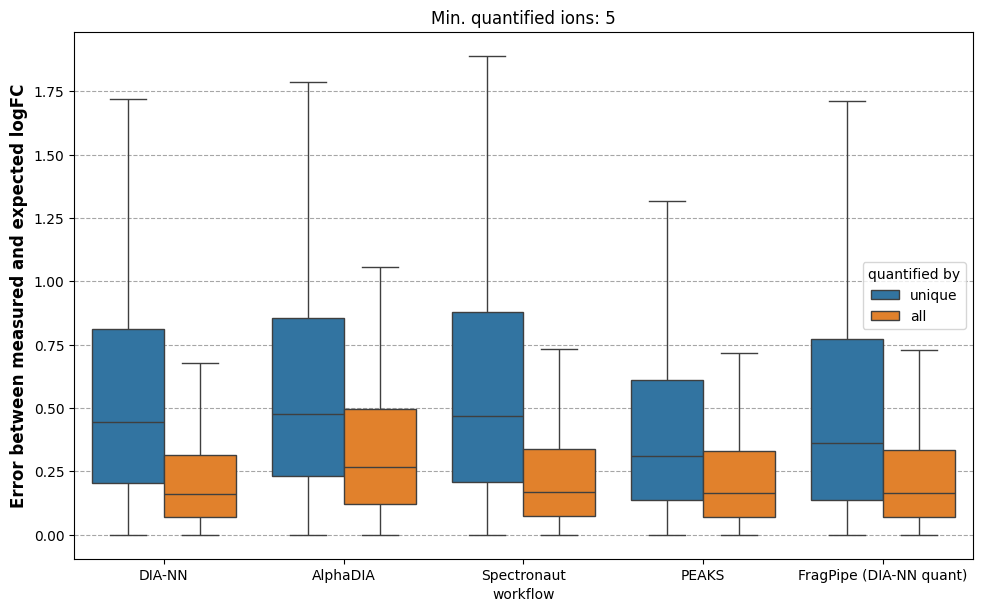

DIA-NN
AlphaDIA
Spectronaut
PEAKS
FragPipe (DIA-NN quant)


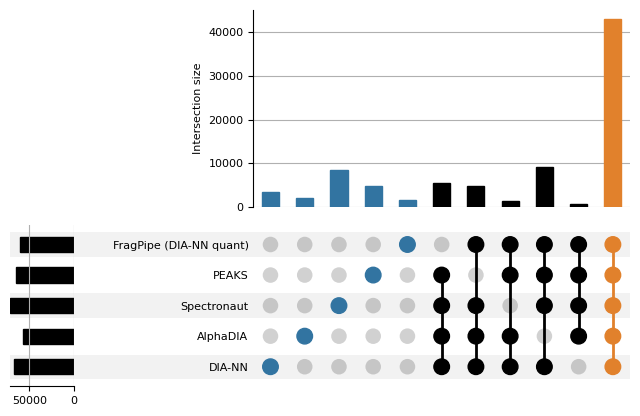

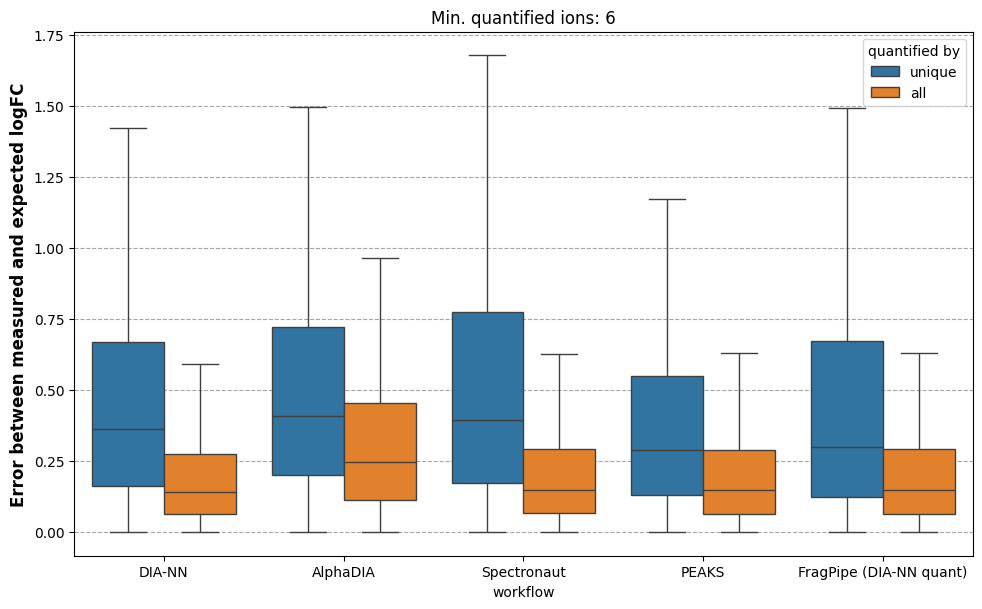

In [ ]:
fig = plot_upset_and_boxplot_all_filters(performance_df_dict, all_tools_mapper, save_path="figures_manuscript/")

# A look at precursor quantification for e.coli and yeast precursors

In [ ]:
def plot_pair_quantifications(
    results,
    subset,
):
    if subset:
        results = {k: {sk: v for sk, v in inner_dict.items() if sk in subset} for k, inner_dict in results.items()}

    lprec = {}
    for tool, subdict in results.items():
        for hashe, df in subdict.items():
            precursors = df["precursor ion"].unique()
            lprec[hashe] = precursors

    # prepare the data for the pair plot
    lplot = []
    for i, (tool, subdict) in enumerate(results.items()):
        for hashe, df in subdict.items():
            res = df[["precursor ion", "log2_A_vs_B", "species"]].copy()
            res["tool"] = tool
            lplot.append(res)

    gtab = pd.concat(lplot, ignore_index=True)
    gtab_wide = gtab.pivot_table(index=["species", "precursor ion"], columns="tool", values="log2_A_vs_B")

    # Get limits for the plots
    lims = np.max(np.abs(gtab[gtab["species"].isin(["ECOLI", "YEAST"])]["log2_A_vs_B"].dropna()))
    lims = (-lims, lims)

    # Create the pair plot for E. coli
    ecoli = gtab_wide[gtab_wide.index.get_level_values("species") == "ECOLI"].reset_index()
    g = sns.pairplot(ecoli.drop(columns=["species", "precursor ion"]), plot_kws={"alpha": 0.1})

    # Apply same axis limits to all subplots in E. coli pairplot
    for i, ax in enumerate(g.axes.flatten()):
        # Skip the diagonal subplots (i.e., where row == column)
        if not i % len(g.axes) == i // len(g.axes):  # Diagonal check
            ax.axhline(y=-2, linestyle="--", linewidth=0.5)
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.axvline(x=-2, linestyle="--", linewidth=0.5)

    plt.suptitle("E. coli Pairplot")
    plt.tight_layout()
    plt.show()

    # Plot for yeast
    yeast = gtab_wide[gtab_wide.index.get_level_values("species") == "YEAST"].reset_index()
    g = sns.pairplot(yeast.drop(columns=["species", "precursor ion"]), plot_kws={"alpha": 0.1})

    # Apply same axis limits to all subplots in Yeast pairplot
    for i, ax in enumerate(g.axes.flatten()):
        # Skip the diagonal subplots (i.e., where row == column)
        if not i % len(g.axes) == i // len(g.axes):  # Diagonal check
            ax.axhline(y=1, linestyle="--", linewidth=0.5)
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.axvline(x=1, linestyle="--", linewidth=0.5)

    plt.suptitle("Yeast Pairplot")
    plt.tight_layout()
    plt.show()


def plot_pair_quantifications_combined(results, subset=None):
    """
    Create a combined pair plot comparing log2(A vs B) fold-changes across multiple tools
    using E. coli (lower triangle) and Yeast (upper triangle) precursor ions.

    Parameters:
        results (dict): Dictionary mapping tool name -> dict of {hash -> DataFrame} with
                        columns ['precursor ion', 'log2_A_vs_B', 'species'].
        subset (list, optional): List of tool names to include in the plot.
    """
    # Filter hashes
    if subset:
        results = {k: {sk: v for sk, v in inner_dict.items() if sk in subset} for k, inner_dict in results.items()}

    tools = list(results.keys())

    # Aggregate DataFrames per tool
    tool_data = {}
    for tool in tools:
        dfs = [df.copy() for df in results[tool].values()]
        tool_data[tool] = pd.concat(dfs, ignore_index=True)

    # Extract species-specific data for each tool, indexed by precursor ion
    e_coli_vals = {}
    yeast_vals = {}
    for tool, df in tool_data.items():
        ecoli_df = df[df["species"].str.upper() == "ECOLI"]
        yeast_df = df[df["species"].str.upper() == "YEAST"]
        e_coli_vals[tool] = ecoli_df.set_index("precursor ion")["log2_A_vs_B"]
        yeast_vals[tool] = yeast_df.set_index("precursor ion")["log2_A_vs_B"]

    # Determine global log2 limits
    all_vals = pd.concat([s.dropna() for d in [e_coli_vals, yeast_vals] for s in d.values()])
    lim = np.ceil(np.percentile(np.abs(all_vals), 99.5)) * 1.1 if not all_vals.empty else 1.0

    # Colors
    col_ecoli = "#1f77b4"
    col_yeast = "#ff7f0e"

    n = len(tools)
    fig, axes = plt.subplots(n, n, figsize=(3 * n, 3 * n))

    for i in range(n):
        for j in range(n):
            ax = axes[i, j]
            tool_i = tools[i]
            tool_j = tools[j]

            if i == j:
                ec_vals = e_coli_vals[tool_i].dropna()
                yt_vals = yeast_vals[tool_i].dropna()
                if not ec_vals.empty:
                    sns.kdeplot(ec_vals, ax=ax, color=col_ecoli, fill=True, alpha=0.4)
                if not yt_vals.empty:
                    sns.kdeplot(yt_vals, ax=ax, color=col_yeast, fill=True, alpha=0.4)
                ax.axvline(-2, linestyle="--", color=col_ecoli, lw=1)
                ax.axvline(1, linestyle="--", color=col_yeast, lw=1)
                ax.set_xlim(-lim, lim)
                if not i == 0:
                    ax.yaxis.set_visible(False)
                if not j == n - 1:
                    ax.xaxis.set_visible(False)

            elif i > j:  # E. coli: lower triangle
                ax.set_facecolor(to_rgba(col_ecoli, alpha=0.1))
                x = e_coli_vals[tool_j]
                y = e_coli_vals[tool_i]
                common = x.index.intersection(y.index)
                ax.scatter(x.loc[common], y.loc[common], color=col_ecoli, alpha=0.3, s=10)
                ax.axhline(-2, linestyle="--", color="gray", lw=0.8)
                ax.axvline(-2, linestyle="--", color="gray", lw=0.8)
                ax.set_xlim(-lim, lim)
                ax.set_ylim(-lim, lim)

            else:  # Yeast: upper triangle
                ax.set_facecolor(to_rgba(col_yeast, alpha=0.1))
                x = yeast_vals[tool_j]
                y = yeast_vals[tool_i]
                common = x.index.intersection(y.index)
                ax.scatter(x.loc[common], y.loc[common], color=col_yeast, alpha=0.3, s=10)
                ax.axhline(1, linestyle="--", color="gray", lw=0.8)
                ax.axvline(1, linestyle="--", color="gray", lw=0.8)
                ax.set_xlim(-lim, lim)
                ax.set_ylim(-lim, lim)

            # Clean ticks
            if i < n - 1:
                ax.set_xticks([])
            else:
                ax.set_xlabel(tool_j)
            if j > 0:
                ax.set_yticks([])
            else:
                ax.set_ylabel(tool_i)

    # Final layout and legend
    fig.legend(
        handles=[
            plt.Line2D([0], [0], color=col_ecoli, lw=4, label="E. coli"),
            plt.Line2D([0], [0], color=col_yeast, lw=4, label="Yeast"),
        ],
        loc="upper right",
        bbox_to_anchor=(1.09, 0.99),
        title="Species",
    )
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

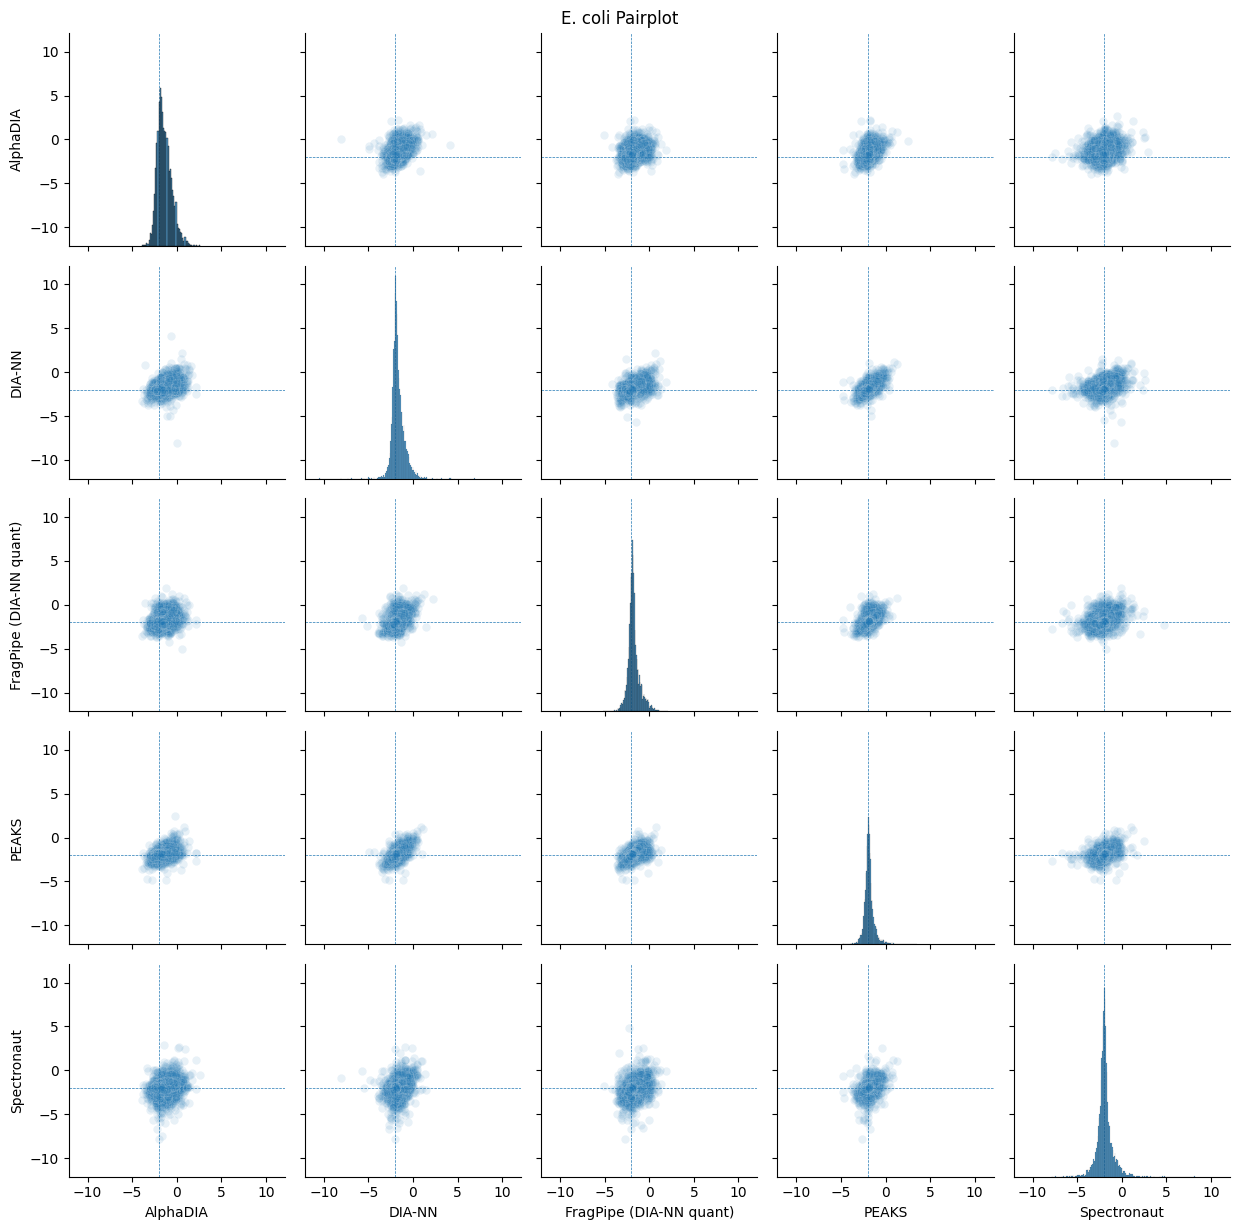

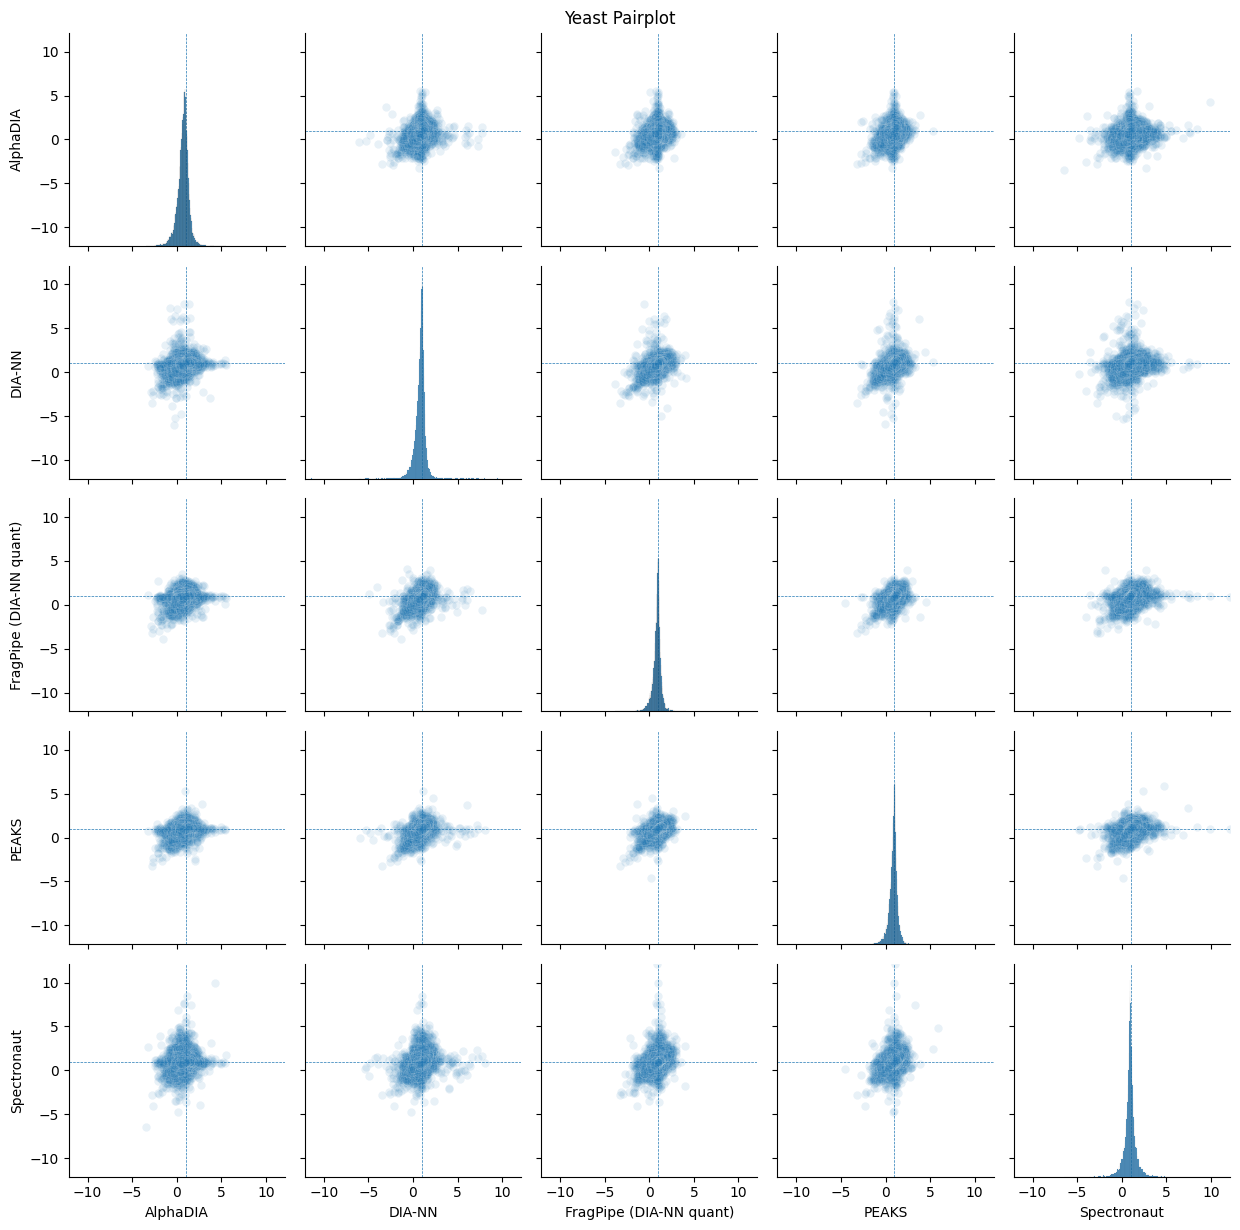

In [94]:
results = plot_pair_quantifications(results_dict, subset=subset_hashes)

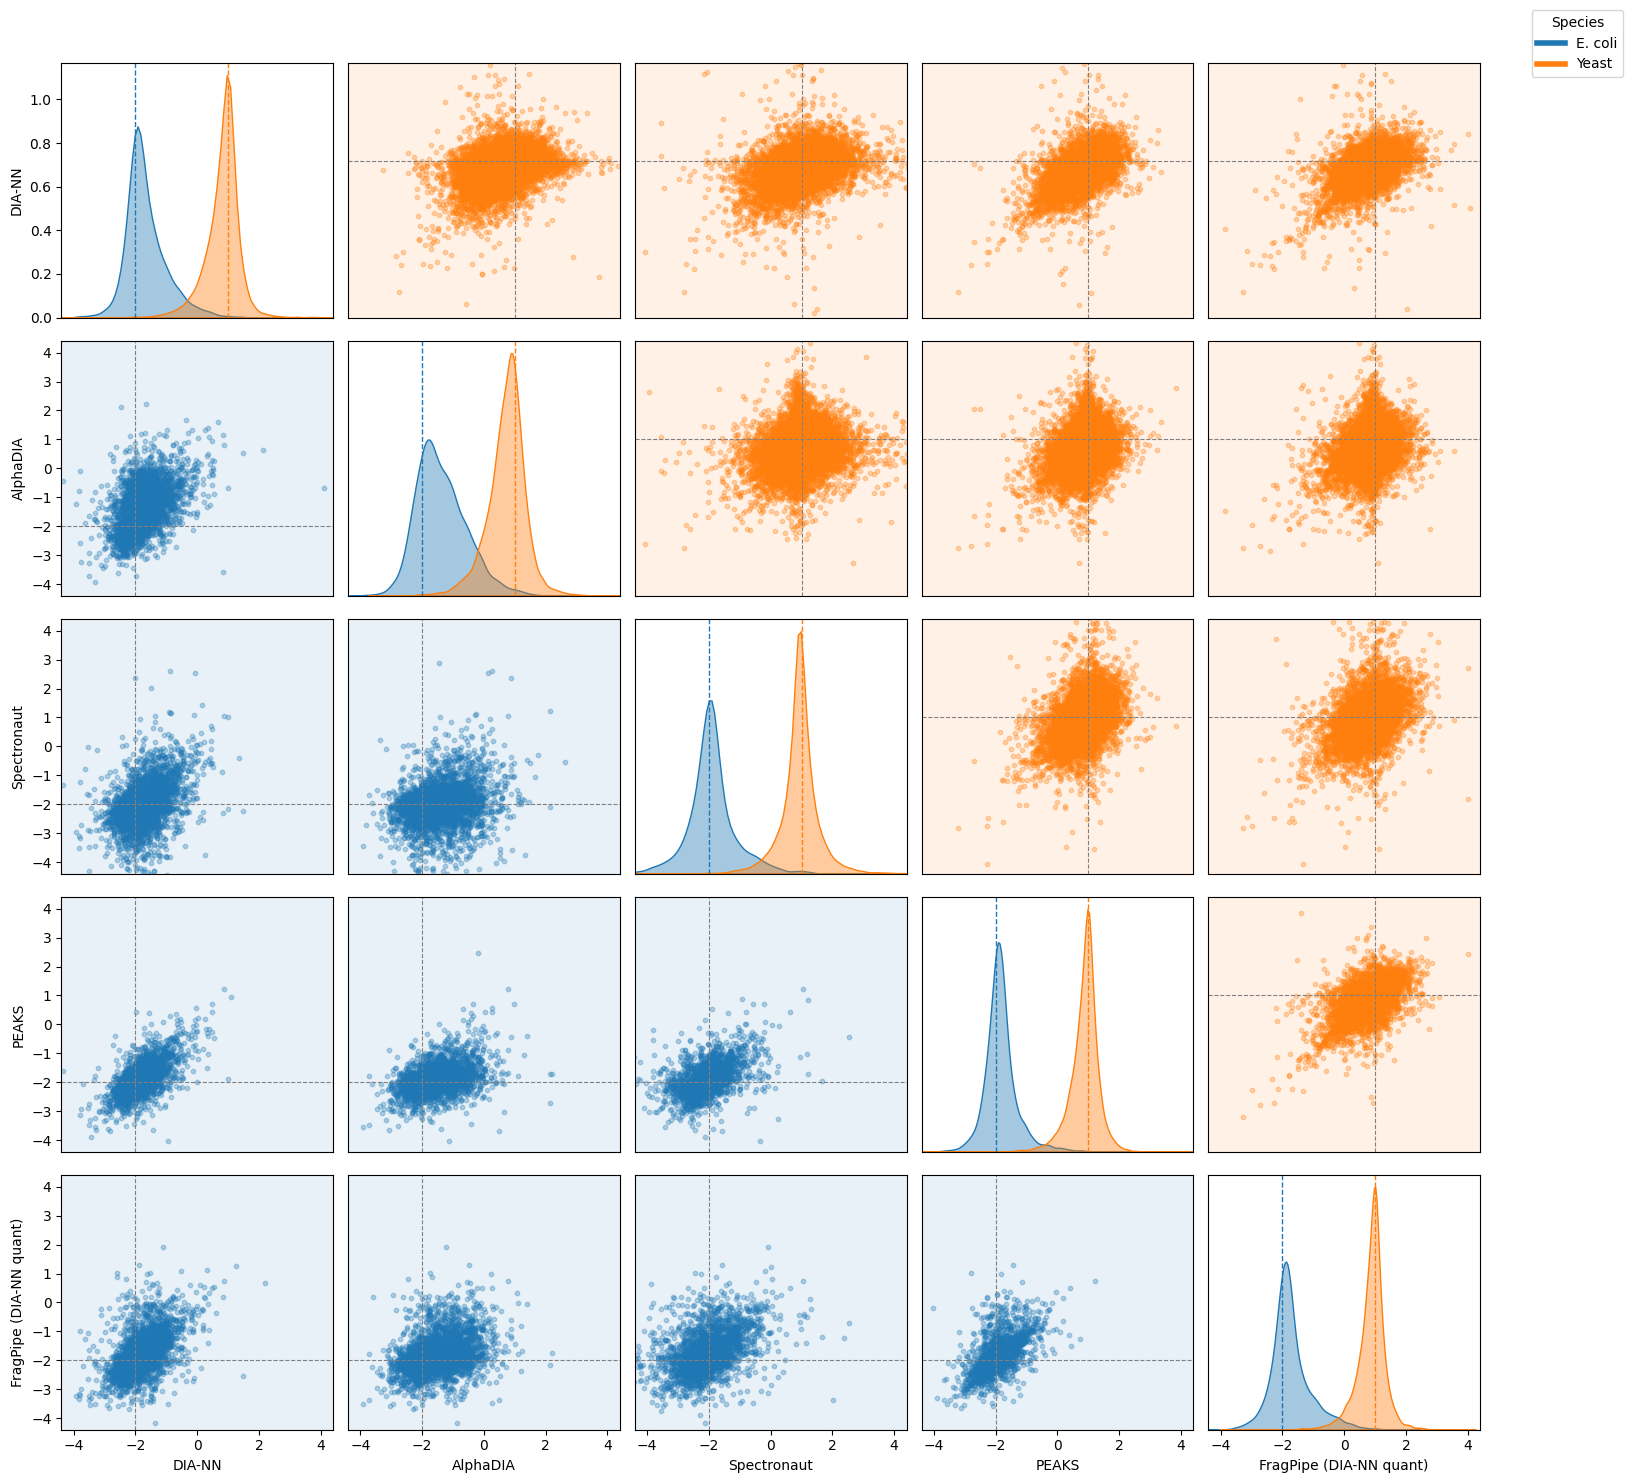

In [95]:
plot_pair_quantifications_combined(results_dict, subset=subset_hashes)

# Comparison with diaPASEF

In [99]:
from proteobench.modules.quant.quant_lfq_ion_DIA_diaPASEF import (
    DIAQuantIonModulediaPASEF,
)

diapasef_module = DIAQuantIonModulediaPASEF("token")

In [ ]:
relevant_points_diapasef = (
    diaPASEF_df[~diaPASEF_df["software_name"].isin(["MaxQuant"])][["software_name", "intermediate_hash"]]
    .set_index("intermediate_hash")
    .to_dict()["software_name"]
)

In [101]:
results_dict_diaPASEF, all_datapoints_diaPASEF = extract_all_from_hashes(
    relevant_points_diapasef,
    data_dir="extracted_files",
    module=diapasef_module,
)

Processing 086b2ad161ee988c6178d533528c15bee4566d4c - DIA-NN
Raw data files found: [PosixPath('extracted_files/086b2ad161ee988c6178d533528c15bee4566d4c/input_file.tsv')]
Parameter files found: [PosixPath('extracted_files/086b2ad161ee988c6178d533528c15bee4566d4c/param_0..txt')]
software_name DIA-NN
search_engine DIA-NN
enable_match_between_runs True
quantification_method Legacy
protein_inference Genes
software_version 1.9.2
search_engine_version 1.9.2
predictors_library {'RT': 'DIANN', 'IM': 'DIANN', 'MS2_int': 'DIANN'}
ident_fdr_psm 0.01
enzyme Trypsin/P
allowed_miscleavages 1
min_peptide_length 6
max_peptide_length 30
fixed_mods unimod4
variable_mods UniMod:35/15.994915/M,UniMod:1/42.010565/*n
max_mods 1
min_precursor_charge 1
max_precursor_charge 4
fragment_mass_tolerance [-11.5251 ppm, 11.5251 ppm]
precursor_mass_tolerance [-13.8504 ppm, 13.8504 ppm]
scan_window 8
abundance_normalization_ions None
Processing 1a119c29266f0b288dddaa073cf1f96d2bf3aa97 - DIA-NN
Raw data files found: [Po

In [102]:
plot = plot_performance_metrics(
    all_datapoints_diaPASEF,
    x_range=[0.1, 0.3],
    y_range=[60000, 150000],
    metric="Median",
    min_quant=3,
)
plot

In [103]:
plot = plot_performance_metrics(
    all_datapoints_diaPASEF,
    x_range=[0.1, 0.4],
    y_range=[60000, 150000],
    metric="Mean",
    min_quant=3,
)
plot

In [104]:
plot = plot_performance_metrics_all_filters(
    all_datapoints_diaPASEF,
    x_range=[0, 0.3],
    y_range=[0, 160000],
    metric="Median",
)
plot

In [105]:
plot = plot_performance_metrics_all_filters(
    all_datapoints_diaPASEF,
    x_range=[0, 0.4],
    y_range=[0, 160000],
    metric="Mean",
)
plot